###  纸板（cardboard）、玻璃（glass）、金属（metal）、纸（paper）、塑料（plastic）、其他垃圾（trash）

In [3]:
import os

data_dir = './Garbage classification/Garbage classification'

classes = os.listdir(data_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash', 'unable']


In [5]:
from torchvision.datasets import ImageFolder  # ImageFolder 类是用于加载具有类别标签的图像数据集的便捷工具
import torchvision.transforms as transforms  # transforms 模块包含用于图像预处理的各种转换操作

# 大小调整为256x256像素，并且转换为Pytorch张量
transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform=transformations)
dataset

Dataset ImageFolder
    Number of datapoints: 2814
    Root location: ./Garbage classification/Garbage classification
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

### 可视化一下数据集图片

paper
标签: 纸6 (类别编号：3)


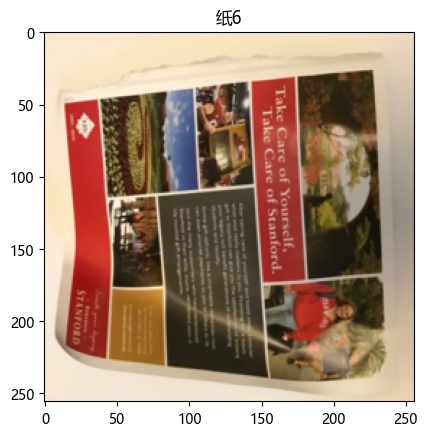

In [14]:
import matplotlib.pyplot as plt

# 中文绘制
plt.rcParams['font.family'] = 'Microsoft YaHei'

# 定义类别名称的中文对应关系
class_mapping = {
    "cardboard": "纸板",
    "glass": "玻璃",
    "metal": "金属",
    "paper": "纸",
    "plastic": "塑料",
    "trash": "其他垃圾"
}


def show_sample(img, label):
    """
    在 PyTorch 中，图像的张量通常是按照 (C, H, W) 的顺序排列的，其中 C 是通道数，H 是图像的高度，W 是图像的宽度。
    而在 matplotlib 中，图像的通道顺序通常是 (H, W, C)。
    :param img:
    :param label:
    :return:
    """
    class_name = class_mapping[dataset.classes[label]]
    print("标签:", class_name, "(类别编号：" + str(label) + ")")

    # 使用 PyTorch 的 permute 函数交换通道顺序，以适应 matplotlib 的图像显示格式
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_name)
    plt.show()


img, label = dataset[1520]
print(dataset.classes[label])
show_sample(img, label)

数据分布

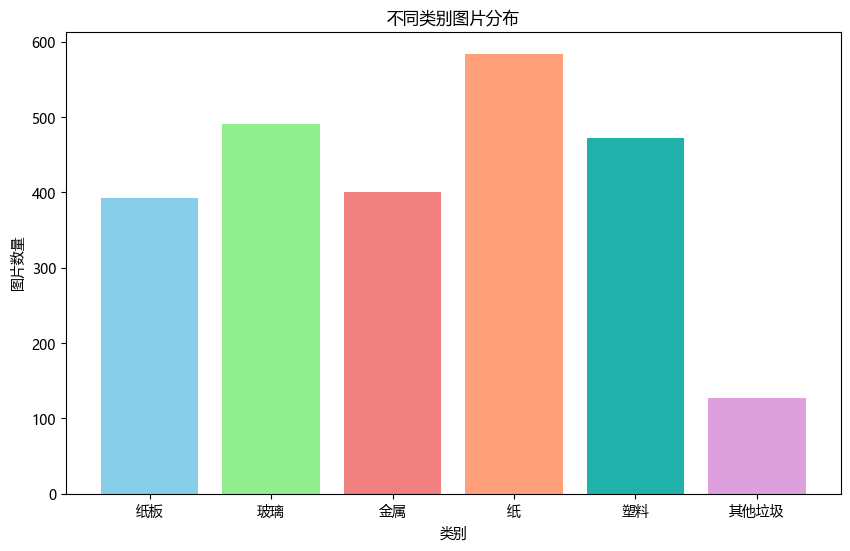

In [9]:
categories = ['纸板', '玻璃', '金属', '纸', '塑料', '其他垃圾']
counts = [393, 491, 400, 584, 472, 127]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightseagreen', 'plum']

plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=colors)
plt.xlabel('类别')
plt.ylabel('图片数量')
plt.title('不同类别图片分布')
plt.show()

In [146]:
import torch

random_seed = 42
torch.manual_seed(random_seed)  # 将随机数生成器的种子设置为指定的值 可复现
torch.cuda.manual_seed(random_seed)  # 在GPU也这么设置

拆分数据集
一共2527张

In [147]:
from torch.utils.data import random_split

# split_sizes = [1593, 176, 758]
split_sizes = [1600, 200, 727]
train_ds, val_ds, test_ds = random_split(dataset, split_sizes)
print("训练集、验证集和测试集大小:")
len(train_ds), len(val_ds), len(test_ds)

训练集、验证集和测试集大小:


(1600, 200, 727)

In [148]:
from torch.utils.data.dataloader import DataLoader

# 定义批量大小
batch_size = 4

# 创建训练集 DataLoader
# shuffle=True 表示在每个 epoch 开始时对数据进行洗牌 就是打乱的意思
# num_workers 表示用于数据加载的子进程数量
# pin_memory=True 可以将数据加载到 CUDA 固定内存中，提高数据传输速度
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

# 创建验证集 DataLoader
# batch_size*2 验证集的批量大小是训练集的两倍
val_dl = DataLoader(val_ds, batch_size * 2, num_workers=4, pin_memory=True)

In [149]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


def show_batch(dl, nrow=8):
    """
    :param dl:
    :param nrow: 每行显示的图像数量 默认为8
    :return:
    """
    # 从数据加载器中获取一个批次的图像和标签
    for images, labels in dl:
        # 创建图形和轴
        fig, ax = plt.subplots(figsize=(12, 6))
        # 移除坐标轴的刻度
        ax.set_xticks([])
        ax.set_yticks([])
        # 使用 make_grid 将图像排列成网格，并在显示之前进行通道顺序的转换
        ax.imshow(make_grid(images, nrow=nrow).permute(1, 2, 0))
        break  # 只显示一个批次的图像

# show_batch(train_dl)

基本模型

In [150]:
import torch
import torch.nn.functional as f
import torch.nn as nn


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(torch.Tensor(preds == labels)).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # 生成预测
        loss = f.cross_entropy(out, labels)  # 计算损失
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # 生成预测
        loss = f.cross_entropy(out, labels)  # 计算损失
        acc = accuracy(out, labels)  # 计算准确率
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        # 将损失列表转换为张量并计算均值
        batch_losses = torch.stack([x['val_loss'] for x in outputs])
        epoch_loss = batch_losses.mean()

        # 将准确率列表转换为张量并计算均值
        batch_accs = torch.stack([x['val_acc'] for x in outputs])
        epoch_acc = batch_accs.mean()

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(
            f"第 {epoch + 1} 轮: 训练损失: {result['train_loss']:.4f}, 验证损失: {result['val_loss']:.4f}, 验证准确率: {result['val_acc']:.4f}")


ResNet50

In [151]:
import torchvision.models as models


class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # 使用预训练模型 ResNet-50
        self.network = models.resnet50(pretrained=True)
        # 替换最后一层全连接层
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

    def forward(self, xb):
        # 使用 sigmoid 函数处理输出
        return torch.sigmoid(self.network(xb))


# 创建 ResNet 模型实例
self = ResNet()

In [152]:
def get_default_device():
    """获取默认设备，如果有 GPU 则选择 GPU，否则选择 CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """将张量（或张量组成的列表/元组）移动到指定的设备"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    """包装数据加载器，将数据移动到指定设备上"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """将数据移动到设备后，产生一个批次的数据"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """批次数量"""
        return len(self.dl)


In [153]:
device = get_default_device()
print("Using device:{}".format(device))

Using device:cuda


In [154]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(self, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

### Training

@torch.no_grad()
告诉 PyTorch 在装饰的代码块中不需要计算梯度。
评估阶段，只关心模型的前向传播，而不需要计算梯度以进行反向传播和参数更新。
在 evaluate 函数中，@torch.no_grad() 装饰器确保了在验证阶段计算损失时不会保存梯度信息，
因为在验证阶段我们只关心模型的性能而不需要进行参数优化。这有助于减少内存占用并提高评估的速度。

In [155]:
@torch.no_grad()
def evaluate(self, val_loader):
    """评估模型在验证集上的性能"""
    self.eval()
    outputs = [self.validation_step(batch) for batch in val_loader]
    return self.validation_epoch_end(outputs)


def fit(epochs, lr, self, train_loader, val_loader, opt_func=torch.optim.SGD):
    """训练模型并在每个 epoch 结束后在验证集上评估性能"""
    history = []
    optimizer = opt_func(self.parameters(), lr)

    for epoch in range(epochs):
        # 训练阶段
        self.train()
        train_losses = []
        for batch in train_loader:
            loss = self.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # 验证阶段
        result = evaluate(self, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        self.epoch_end(epoch, result)
        history.append(result)

    return history


In [156]:
self = to_device(ResNet(), device)
evaluate(self, val_dl)  # 验证集损失和验证集准确率

{'val_loss': 1.784023404121399, 'val_acc': 0.20999999344348907}

开始训练

In [157]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, self, train_dl, val_dl, opt_func)

第 1 轮: 训练损失: 1.4348, 验证损失: 1.2148, 验证准确率: 0.8350
第 2 轮: 训练损失: 1.2951, 验证损失: 1.2301, 验证准确率: 0.8100
第 3 轮: 训练损失: 1.2439, 验证损失: 1.1415, 验证准确率: 0.9150
第 4 轮: 训练损失: 1.1770, 验证损失: 1.1391, 验证准确率: 0.9200
第 5 轮: 训练损失: 1.1465, 验证损失: 1.1299, 验证准确率: 0.9150
第 6 轮: 训练损失: 1.1268, 验证损失: 1.1266, 验证准确率: 0.9300
第 7 轮: 训练损失: 1.1074, 验证损失: 1.1410, 验证准确率: 0.9100
第 8 轮: 训练损失: 1.1017, 验证损失: 1.1388, 验证准确率: 0.9150
第 9 轮: 训练损失: 1.0880, 验证损失: 1.1287, 验证准确率: 0.9100
第 10 轮: 训练损失: 1.0885, 验证损失: 1.1369, 验证准确率: 0.9000


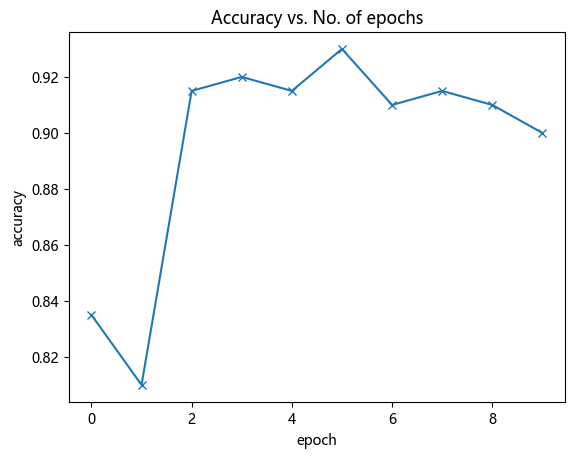

In [158]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')


plot_accuracies(history)

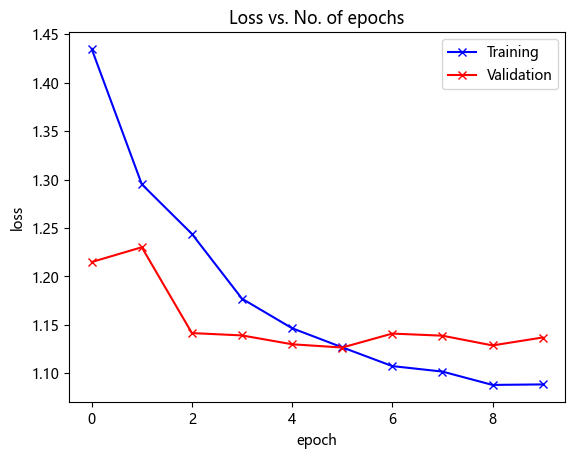

In [159]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')


plot_losses(history)

In [163]:
# 保存模型参数
torch.save(self.state_dict(), 'self/model_weights.pth')

In [164]:
# 保存整个模型
torch.save(self, 'self/entire_model.pth')

In [166]:
# 加载整个模型
self = torch.load('self/entire_model.pth')
# 获取模型的所有层
layers = list(self.children())

# 遍历所有层并打印它们
for layer in layers:
    print(layer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 